# 환경설정

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [3]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [ ]:
!pip install hanja
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch
!pip install hanja
!pip install imblearn
!pip install WordCloud
!apt-get install fonts-nanum*
!apt-get install fontconfig

In [1]:
# 필요한 라이브러리들을 불러옵니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import re
from collections import defaultdict, Counter
import hanja
import konlpy

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

# 데이터 전처리 및 시각화

In [2]:
# 이번에 진행할 프로젝트는 뉴스토픽 분류모델 파이프라인을 만들어 보는 것입니다.

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_file_2/train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_file_2/test_data.csv')
topic_dict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_file_2/topic_dict.csv')

In [3]:
# 데이터를 전처리 해줍니다.
train_df.drop('index', axis=1, inplace=True)

In [4]:
train_df

,title,topic_idx
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...
45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1
45652,답변하는 배기동 국립중앙박물관장,2


In [5]:
test_df.drop('index', axis=1, inplace=True)

In [6]:
test_df

,title
0,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
...,...
9126,인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여
9127,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
9128,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개
9129,게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계


In [7]:
topic_dict = pd.DataFrame.to_dict(topic_dict)

In [8]:
topic_dict['topic']

{0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'}

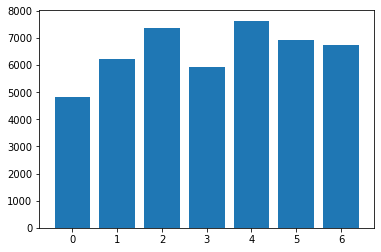

In [9]:
# 뉴스 토픽의 분포도를 시각화하여 봅니다.
plot_train = train_df.groupby(train_df.topic_idx).size().reset_index(name="counts")
plt.bar(x='topic_idx', height='counts', data=plot_train)
plt.savefig('토픽분포도.jpg', dpi=144);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


 가장 긴 문장은 13 개의 단어를, 가장 짧은 문장은 1 개의 단어를 가지고 있습니다.


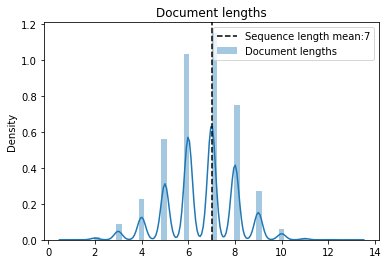

In [10]:
# 토픽 길이 분포도 확인
train_df['topic_len'] = train_df.title.apply(lambda words: len(words.split()))

def length_distribution(dataframe):
    mean_seq_len = np.round(dataframe.topic_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.topic_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    print(f" 가장 긴 문장은 {train_df['topic_len'].max()} 개의 단어를, 가장 짧은 문장은 {train_df['topic_len'].min()} 개의 단어를 가지고 있습니다.")
length_distribution(train_df)
plt.savefig('문장과 단어의 관계.jpg', dpi=144);

In [11]:
plt.rc('font', family='NanumBarunGothic') 

In [12]:
# 한국어의 경우 일반적인 tokenizer로 토큰화시킨 후 벡터화 시키면 정확도가 많이 떨어집니다.
# 한국어에 특화되어있는 라이브러리를 써야합니다.
from konlpy.tag import Mecab

mecab = Mecab()

titles = train_df['title']
topic_idx = train_df['topic_idx']
token_sentences = [mecab.morphs(text) for text in titles]

In [13]:
# 토큰화 결과를 관찰합니다.
token_sentences[0]

['인천', '→', '핀란드', '항공기', '결항', '…', '휴가철', '여행객', '분통']

In [14]:
# 토픽 별 많이 들어있는 단어를 세기 위해 Counter를 사용합니다.
counter = Counter()
for title in token_sentences:
  counter.update(title)

(-0.5, 399.5, 199.5, -0.5)

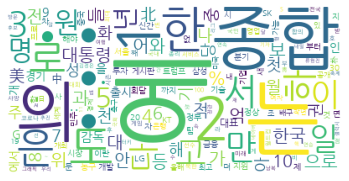

In [15]:
from wordcloud import WordCloud

# 전체
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
wc = WordCloud(font_path = FONT_PATH,
                 background_color = "white")
cloud = wc.generate_from_frequencies(counter)
plt.imshow(cloud)
plt.axis('off')

In [16]:
# 토픽 별로 많이 나오는 단어를 시각화하기위해 counter로 횟수를 세줘야합니다.
# counter에 입력이 가능하게끔 데이터를 정리해줍니다.
# 우선 topic별로 나눠주는 과정을 거칩니다.
df_list = []
for i in range(7):
  df_list.append(train_df.loc[train_df.topic_idx==i])

In [17]:
# 기사 제목만 따로 뽑아서 list에 저장해줍니다.
title_list = []
for i in range(7):
  title_list.append(df_list[i].title.to_numpy())

title_list

[array(['지카바이러스도 규명한 초저온전자현미경…신약연구에 유용', '증강현실 ① 알파고 이어 포켓몬 고…거센 IT 광풍',
        'AI 월드컵 생생한 현장 중계도', ..., '알코올 중독 유전적 연관성 더 확실해졌다',
        '첫돌 전 아기 배앓이 잦은 까닭은 공생균 결여 때문', '구글 받아쓰기 앱 시험판 출시…한국어도 지원'],
       dtype=object),
 array(['못믿을 아파트 관리비…경기 556곳서 150억 비리 적발종합', '특징주 관리종목 해제 대우조선해양 강세',
        '특징주 강원랜드 실적 부진에 급락종합', ..., '금융소비자연맹 증권사 안정성 1위는 도이치…수익성은 메리츠',
        'KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략', '게시판 키움증권 2020 키움 영웅전 실전투자대회'],
       dtype=object),
 array(['드라마 제작환경 개선 촉구', '창원세계사격대회장서 경남 시·군 관광 세계에 알린다종합',
        '조배숙 중앙위 정례회의 주재', ..., '1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토',
        '답변하는 배기동 국립중앙박물관장', '2020 한국인터넷기자상 시상식 내달 1일 개최…특별상 김성후'],
       dtype=object),
 array(['황석영 작가 미국 문학축제서 한국문학 알린다', '휴일 불청객 울산 미세먼지 주의보 발령',
        '김수영 신임 한국출판문화산업진흥원장', ..., '기고 아인슈타인 지휘에 맞춰 블랙홀 듀엣 연주가 시작됐다',
        '장석주 시인 사랑은 새로운 이야기가 잉태되는 순간', '인류문명사로 본 세계 종교의 탄생과 성장'],
       dtype=object),
 array(['인천→핀란드 항공기 결항…휴가철 여행객 분통', '실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화',
        '이란 외무 긴장완화 해결책은 미국이 경제전

In [18]:
# 리스트에 있는 기사제목을 토큰화 시킵니다.
filter_pos = ['NNP', 'NNG','SL']# 명사, 외래어 출력
token_sentence_list = []
for i in range(7):
  titles = title_list[i]
  token_sentences = [word for text in titles for word, pos in mecab.pos(text) if pos in filter_pos]
  token_sentence_list.append(token_sentences)

token_sentence_list[0]

['지카',
 '바이러스',
 '규명',
 '초저',
 '전자',
 '현미경',
 '신약',
 '연구',
 '유용',
 '증강현실',
 '알파',
 '포켓',
 'IT',
 '광풍',
 'AI',
 '월드컵',
 '현장',
 '중계',
 '이세돌',
 '알파',
 '집중력',
 '사람',
 '일문일답',
 '종합',
 '올해',
 '휴대폰',
 '국내',
 '생산량',
 '전',
 'LG',
 '노트',
 '겨냥',
 'V',
 '티저',
 '광고',
 '선전',
 '포고',
 'KT',
 '스카이',
 '라이프',
 '알뜰',
 '폰',
 '판매',
 '전용',
 '요금제',
 '종',
 '출시',
 'TV',
 '주파수',
 '농어촌',
 '무선',
 '인터넷',
 '과학',
 '과학',
 '달',
 '행사',
 '풍성',
 '과기',
 '정통부',
 '실험실',
 '창업',
 '사업',
 '공모',
 '규모',
 '삼성전자',
 'G',
 '기술',
 'MWC',
 '공식',
 '방송',
 '단독',
 '중계',
 '알파',
 '인간',
 '직관',
 '모방',
 '학습',
 '파티',
 'LG',
 'G',
 '붐',
 '박스',
 '스피커',
 '눈길',
 'KT',
 '영업',
 '이익',
 '돌파',
 '실적',
 '종합',
 '인공지능',
 '박지성',
 'KAIST',
 '세계',
 'AI',
 '월드컵',
 'G',
 '스마트',
 'MWC',
 '흥행',
 '몰',
 'LG',
 'G',
 'X',
 '듀얼',
 '스크린',
 '브라질',
 '출시',
 '중남미',
 '공략',
 '가속',
 '인터넷',
 '흥원',
 '우수',
 '정보',
 '보호',
 '기술',
 '지정',
 '제도',
 '시행',
 'SKT',
 'MWC',
 'Gbps',
 '속도',
 'G',
 '공공장소',
 '시연',
 '중이온',
 '가속기',
 '라온',
 '핵심',
 '장치',
 '성능',
 '시험',
 '성공',
 '세계',
 'LG',
 '전자',
 '

In [19]:
# 토큰화한 단어들의 빈도를 저장해줍니다.
counter_list = []
for i in range(7):
  counter = Counter(token_sentence_list[i])    
  counter_list.append(counter)

(-0.5, 399.5, 199.5, -0.5)

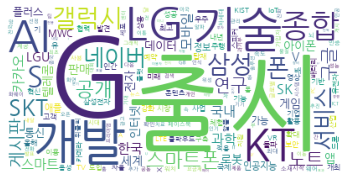

In [20]:
# IT과학
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
wc = WordCloud(font_path = FONT_PATH,
                 background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[0])
plt.imshow(cloud)
plt.axis('off')

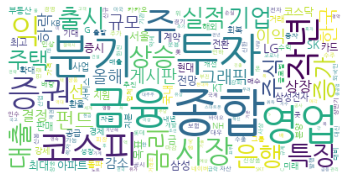

In [21]:
# 경제
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
wc = WordCloud(font_path = FONT_PATH,
                background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[1])
plt.imshow(cloud)
plt.axis('off')
plt.savefig('경제 단어 빈도.jpg', dpi=144);

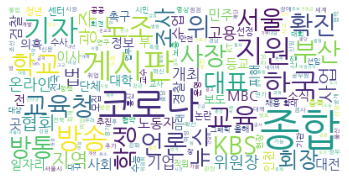

In [22]:
# 사회 {0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'}
wc = WordCloud(font_path = FONT_PATH,
                background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[2])
plt.imshow(cloud)
plt.axis('off')
plt.savefig('사회 단어 빈도.jpg', dpi=144);

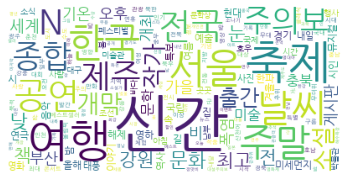

In [23]:
# 생활문화
wc = WordCloud(font_path = FONT_PATH,
                background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[3])
plt.imshow(cloud)
plt.axis('off')
plt.savefig('생활문화 단어 빈도.jpg', dpi=144);

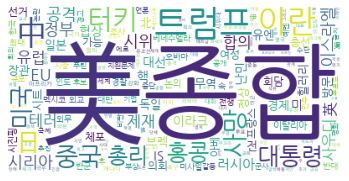

In [24]:
# 세계
wc = WordCloud(font_path = FONT_PATH,
                background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[4])
plt.imshow(cloud)
plt.axis('off')
plt.savefig('세계 단어 빈도.jpg', dpi=144);

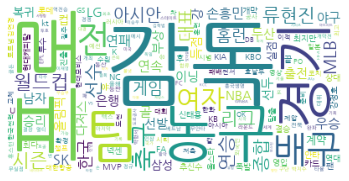

In [25]:
# 스포츠
wc = WordCloud(font_path = FONT_PATH,
                background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[5])
plt.imshow(cloud)
plt.axis('off')
plt.savefig('스포츠 단어 빈도.jpg', dpi=144);

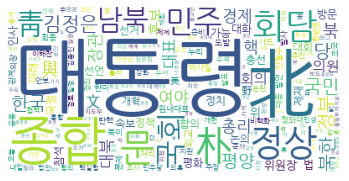

In [26]:
# 정치
wc = WordCloud(font_path = FONT_PATH,
                background_color = "white")
cloud = wc.generate_from_frequencies(counter_list[6])
plt.imshow(cloud)
plt.axis('off')
plt.savefig('정치 단어 빈도.jpg', dpi=144);

# Model1. 양방향 LSTM

In [27]:
# DL 모델에 학습시키기위해서는 자연어 데이터를 벡터화 시켜줘야합니다. 
# 영어의 경우 많이 쓰는 Tokenizer를 사용하면 되지만 한국어의 경우 다른 라이브러리를 사용해야합니다.

# 일단 Tokenizer에 fit해주기위해 자연어를 배열로 만들어줍니다.
X_train = np.array([x for x in train_df['title']])
X_test = np.array([x for x in test_df['title']])
Y_train = np.array([x for x in train_df['topic_idx']])

In [28]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(45654,)
(9131,)
(45654,)


In [29]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
vocab_size = 2000  

tokenizer = Tokenizer(num_words = vocab_size)  
  
# Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 
# num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환합니다                 
tokenizer.fit_on_texts(X_train) # Tokenizer 에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train) # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)   # 문장 내 모든 단어를 시퀀스 번호로 변환

print(len(sequences_train), len(sequences_test))

45654 9131


In [30]:
print(sequences_train)
print(sequences_test)

[[], [], [11, 576, 13], [], [332, 1775, 1235, 936], [1389, 70], [382, 15, 1685, 1947], [1437, 477], [614, 339, 877, 94, 821, 45, 97], [737, 1272, 14, 504, 505, 1948], [98, 955, 561], [1501, 348, 1107, 1390, 1866], [300, 956], [1686, 365, 68, 1687], [98, 1949, 24, 466, 80, 654], [998, 69], [130, 716, 1273, 227], [1438, 139, 288, 8, 999], [562, 228, 717], [1950, 491], [128, 210, 141, 18, 1564, 492, 684, 383], [105, 957, 215, 28], [14, 168], [107, 244, 1000], [431, 6, 49, 1688, 718], [8, 738, 14, 30, 1502, 13], [130, 716, 739, 535], [130, 716, 114, 1179, 104, 1108, 182, 718], [14, 51], [50, 90, 51, 425, 142], [1503, 113, 615], [146], [1438, 1109], [235, 108, 94], [73, 937, 1504], [455, 1339, 276], [1951], [655, 42, 339, 306, 174, 119], [], [1867, 195, 108, 200, 1391, 189, 577], [8, 151, 20, 301, 432, 578], [59, 1619, 106, 1138, 1565], [365, 77], [478], [11, 1501, 8], [1566, 201], [70], [633, 1686], [958, 910, 1180, 73], [10, 1340, 479], [138, 1776, 140, 878, 349], [247, 1061, 563, 1868], 

In [31]:
# 변환된 시퀀스 번호를 이용해 단어 임베딩 벡터를 생성합니다. 
word_index = tokenizer.word_index

# 문장의 길이기 제각각이기 때문에 벡터의 크기가 다 다릅니다.
# 그러므로 최대 시퀀스 길이 크기(211) 만큼 넉넉하게 늘리고 패딩을 통해 나머지 빈 공간을 0으로 채웁니다.

max_length = 14 # 위에서 확인한 결과 가장 긴 길이가 13입니다. 따라서 14로 정해줍니다.
padding_type='post'

train_x = pad_sequences(sequences_train, padding='post', maxlen=max_length)
test_x = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

print(train_x.shape, test_x.shape)

(45654, 14) (9131, 14)


In [32]:
from keras.utils import np_utils

train_y = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩
print(train_y)
print(train_y.shape)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(45654, 7)


In [33]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200

# 양방향 LSTM 레이어를 사용한 모델을 정의합니다.
model1 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)), # 두 계층을 연결하기 위해 bidirectional layer를 사용합니다.
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(7, activation='softmax')    # 결과값이 0~6 이므로 Dense는 7입니다.
    ])
    
model1.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy입니다.
              optimizer= 'adam',
              metrics = ['accuracy']) 
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 200)           400000    
_________________________________________________________________
bidirectional (Bidirectional (None, 14, 128)           135680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 128)           98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 734,215
Trainable params: 734,215
Non-trainable params: 0
_________________________________________________________________


In [34]:
type(train_y)

numpy.ndarray

In [35]:
history = model1.fit(train_x, train_y, epochs=50, batch_size=100, validation_split= 0.2) 

Epoch 1/50
366/366 [==============================] - 22s 25ms/step - loss: 1.0591 - accuracy: 0.6114 - val_loss: 1.1748 - val_accuracy: 0.5596
Epoch 2/50
366/366 [==============================] - 7s 20ms/step - loss: 0.7781 - accuracy: 0.7349 - val_loss: 1.1841 - val_accuracy: 0.5328
Epoch 3/50
366/366 [==============================] - 7s 20ms/step - loss: 0.7317 - accuracy: 0.7455 - val_loss: 1.2103 - val_accuracy: 0.5420
Epoch 4/50
366/366 [==============================] - 8s 21ms/step - loss: 0.7038 - accuracy: 0.7547 - val_loss: 1.1448 - val_accuracy: 0.5776
Epoch 5/50
366/366 [==============================] - 8s 21ms/step - loss: 0.6872 - accuracy: 0.7592 - val_loss: 1.1552 - val_accuracy: 0.5603
Epoch 6/50
366/366 [==============================] - 8s 21ms/step - loss: 0.6674 - accuracy: 0.7620 - val_loss: 1.1065 - val_accuracy: 0.5775
Epoch 7/50
366/366 [==============================] - 7s 20ms/step - loss: 0.6511 - accuracy: 0.7662 - val_loss: 1.0963 - val_accuracy: 0.601

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


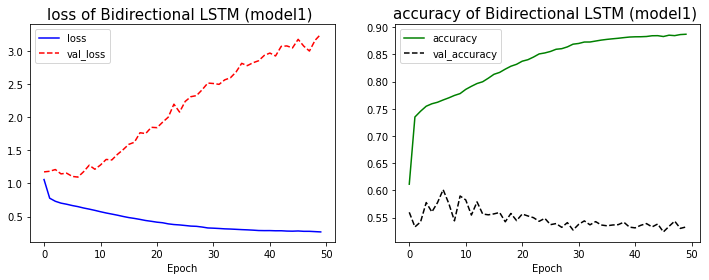

In [36]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (model1) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (model1) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('양방향 LSTM 결과.jpg', dpi=144)

교차검증을 통해 정확도를 높여봐야겠습니다.

In [37]:
import keras
# 계층 교차 검증
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

# 테스트데이터의 예측값 담을 곳 생성합니다.
test_y = np.zeros((test_x.shape[0], 7))

# 조기 종료 옵션을 추가합니다.
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    keras.backend.clear_session()
    print(f'training model for CV #{i}')

    model1.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
                      
    test_y += model1.predict(test_x) / 5    # 나온 예측값들을 교차 검증 횟수로 나눕니다.

training model for CV #1
Epoch 1/10
72/72 [==============================] - 2s 26ms/step - loss: 0.6558 - accuracy: 0.8207 - val_loss: 0.5725 - val_accuracy: 0.8250
Epoch 2/10
72/72 [==============================] - 2s 25ms/step - loss: 0.4732 - accuracy: 0.8426 - val_loss: 0.5564 - val_accuracy: 0.8264
Epoch 3/10
72/72 [==============================] - 2s 24ms/step - loss: 0.4191 - accuracy: 0.8535 - val_loss: 0.5569 - val_accuracy: 0.8246
Epoch 4/10
72/72 [==============================] - 2s 24ms/step - loss: 0.3884 - accuracy: 0.8601 - val_loss: 0.5636 - val_accuracy: 0.8247
Epoch 5/10
72/72 [==============================] - 2s 25ms/step - loss: 0.3677 - accuracy: 0.8635 - val_loss: 0.5728 - val_accuracy: 0.8221
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping
training model for CV #2
Epoch 1/10
72/72 [==============================] - 2s 23ms/step - loss: 0.4582 - accuracy: 0.8445 - val_loss: 0.4140 - val_accuracy: 0.8555
Epoch 2/10
72/72 [==

In [38]:
test_y

array([[8.04711059e-02, 8.31442198e-03, 9.09328088e-01, ...,
        8.89705680e-05, 5.68159261e-06, 5.97598769e-05],
       [8.06210618e-02, 1.06899932e-01, 2.32997131e-01, ...,
        1.09529426e-01, 7.24539245e-02, 1.21578055e-01],
       [3.26470890e-05, 9.87622976e-01, 1.23423024e-02, ...,
        6.39517147e-07, 3.50047721e-07, 7.31598902e-07],
       ...,
       [4.82996904e-04, 1.07021837e-06, 9.98613343e-01, ...,
        8.76988404e-07, 4.43974361e-05, 1.37560130e-06],
       [6.62944548e-01, 2.10952569e-05, 1.68405823e-01, ...,
        1.56633069e-02, 5.75862496e-05, 6.66963123e-03],
       [5.95903430e-07, 6.84306913e-08, 9.87829521e-01, ...,
        8.08908346e-05, 6.48169284e-07, 1.18343079e-02]])

In [39]:
topic = []
for i in range(len(test_y)):
    topic.append(np.argmax(test_y[i]))

In [40]:
topic

[2,
 3,
 1,
 2,
 3,
 0,
 5,
 3,
 4,
 4,
 6,
 6,
 4,
 0,
 6,
 1,
 6,
 2,
 4,
 0,
 4,
 4,
 4,
 3,
 0,
 3,
 6,
 6,
 5,
 2,
 5,
 1,
 3,
 5,
 2,
 4,
 5,
 4,
 6,
 5,
 5,
 3,
 5,
 2,
 0,
 5,
 2,
 6,
 1,
 1,
 0,
 4,
 6,
 4,
 5,
 0,
 6,
 6,
 4,
 3,
 4,
 4,
 6,
 5,
 3,
 2,
 5,
 5,
 2,
 6,
 3,
 4,
 2,
 3,
 4,
 5,
 1,
 2,
 1,
 2,
 6,
 1,
 5,
 2,
 6,
 5,
 5,
 1,
 6,
 1,
 5,
 5,
 4,
 4,
 4,
 3,
 6,
 2,
 0,
 1,
 5,
 6,
 2,
 4,
 5,
 4,
 2,
 4,
 1,
 3,
 2,
 2,
 3,
 4,
 3,
 5,
 3,
 3,
 0,
 2,
 5,
 3,
 6,
 1,
 4,
 1,
 5,
 4,
 0,
 4,
 1,
 6,
 6,
 4,
 4,
 2,
 2,
 2,
 1,
 3,
 3,
 0,
 3,
 2,
 4,
 2,
 1,
 1,
 3,
 6,
 6,
 0,
 1,
 6,
 4,
 5,
 6,
 3,
 5,
 6,
 1,
 5,
 3,
 1,
 5,
 3,
 4,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 3,
 4,
 2,
 3,
 6,
 3,
 5,
 1,
 5,
 2,
 5,
 3,
 6,
 0,
 3,
 5,
 5,
 2,
 0,
 2,
 3,
 6,
 6,
 0,
 3,
 1,
 1,
 3,
 4,
 6,
 5,
 3,
 5,
 5,
 1,
 0,
 3,
 1,
 3,
 3,
 1,
 0,
 2,
 0,
 6,
 2,
 4,
 3,
 5,
 1,
 0,
 5,
 0,
 2,
 5,
 3,
 6,
 0,
 3,
 6,
 4,
 4,
 5,
 1,
 4,
 1,
 5,
 5,
 2,
 6,
 0,
 4,
 6,
 4,
 6,
 4,


In [48]:
topic_dict

{'topic': {0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'},
 'topic_idx': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}}

In [49]:
print(test_df.iloc[100])
print(topic[100])

title    트레이드 성사한 잠실구장 두 사령탑 불펜 투수가 필요했다
Name: 100, dtype: object
5


In [50]:
from transformers import ElectraTokenizerFast, ElectraModel, TFElectraModel

In [52]:
from transformers import ElectraTokenizerFast, ElectraModel, TFElectraModel
tokenizer_electra = ElectraTokenizerFast.from_pretrained("kykim/electra-kor-base")

model_electra_tf = TFElectraModel.from_pretrained("kykim/electra-kor-base")  # tensorflow

All model checkpoint layers were used when initializing TFElectraModel.

All the layers of TFElectraModel were initialized from the model checkpoint at kykim/electra-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


In [53]:
model_electra_tf.summary()

Model: "tf_electra_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
electra (TFElectraMainLayer) multiple                  117706752 
Total params: 117,706,752
Trainable params: 117,706,752
Non-trainable params: 0
_________________________________________________________________


In [55]:
model_electra_tf.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy입니다.
              optimizer= 'adam',
              metrics = ['accuracy']) 

In [57]:
history_2 = model_electra_tf.fit(train_x, train_y, epochs=50, batch_size=100, validation_split= 0.2)

Epoch 1/50


ValueError: ignored